In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dtreeviz.trees import *
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
#data = pd.read_csv('~/data/kobe/data.csv')
data = pd.read_csv('~/desktop/finalproject/data.csv')
data = data[data.shot_made_flag.notnull()].reset_index()

In [6]:
data['opponent'] = data.apply(lambda row: 'NOH' if row['season'] == '2004-05' and row['opponent'] == 'NOP' else row['opponent'], axis=1)

In [7]:
defense = pd.read_pickle('./defense_scrape/defense.pkl')
data = data.merge(defense, left_on=['opponent', 'season'], right_on=['Team_Abb', 'Season'], how='left')

In [8]:
def evaluateModel(model):
    print(f'Test Accuracy: {model.score(X_test, y_test):.4f}')
    print(f'Test Log-Loss: {log_loss(y_test, model.predict_proba(X_test)):.4f}')
    print(f'Training Accuracy: {model.score(X_train, y_train):.4f}')

In [9]:
def featureImportance(model):
    feature_importance = list(zip(list(X),model.feature_importances_))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    for f in feature_importance:
        print(f'{f[0]}: {f[1]}')

# Model 1: Random Forest

In [10]:
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup', 
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60*dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type', 'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
rf = RandomForestClassifier(n_estimators=200)
grid_params = {'criterion':['entropy'],
               'min_samples_leaf':np.arange(1,20,2)
              }
gs = GridSearchCV(estimator=rf,  
                  param_grid=grid_params,
                  scoring='neg_log_loss',
                  cv=5)
gs.fit(X_train, y_train)
evaluateModel(gs)
print(f"{gs.best_estimator_}")

KeyboardInterrupt: 

In [29]:
gs.best_estimator_timator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', min_samples_leaf=5, n_jobs=-1)
rf.fit(X_train, y_train)
evaluateModel(rf)

Test Accuracy: 0.6868
Test Log-Loss: 0.6038
Training Accuracy: 0.7115


In [107]:
featureImportance(rf)

action_type#Jump Shot: 0.15763979228482464
total_seconds_remaining: 0.1252699463678601
shot_distance: 0.11835617926550474
Def_Rtg: 0.09628189438979101
action_type#Layup Shot: 0.04528510501102002
action_type#Slam Dunk Shot: 0.031348561779122895
action_type#Driving Layup Shot: 0.029567223375038837
home: 0.025264398225596743
action_type#Driving Dunk Shot: 0.02156978167235983
shot_zone_area#Center(C): 0.02150312113703447
action_type#Running Jump Shot: 0.020264865358148993
period#3: 0.014777433335774375
period#4: 0.012979604099524844
period#2: 0.01227469082076166
month#03: 0.010668524394727052
month#12: 0.010480477937415437
month#11: 0.009880789817749218
month#02: 0.009734163691169162
action_type#Jump Bank Shot: 0.009516035652796075
month#04: 0.009030753571406959
action_type#Pullup Jump shot: 0.008338100650411769
action_type#Turnaround Jump Shot: 0.007662367505697507
shot_zone_area#Right Side(R): 0.007555060283095767
playoffs: 0.007473838942173687
shot_zone_area#Right Side Center(RC): 0.007

# Model 2: Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [67]:
features = ['shot_distance', 'shot_made_flag']
X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)
dataset = data[features]

In [19]:
lr = LogisticRegression(C=10e4)
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6118
Test Log-Loss: 0.6620
Training Accuracy: 0.5928


In [20]:
dist = np.linspace(dataset.shot_distance.min(), dataset.shot_distance.max(), 1000)
probs = lr.predict_proba(X=dist.reshape(-1,1))

In [21]:
thresh = -lr.intercept_/lr.coef_

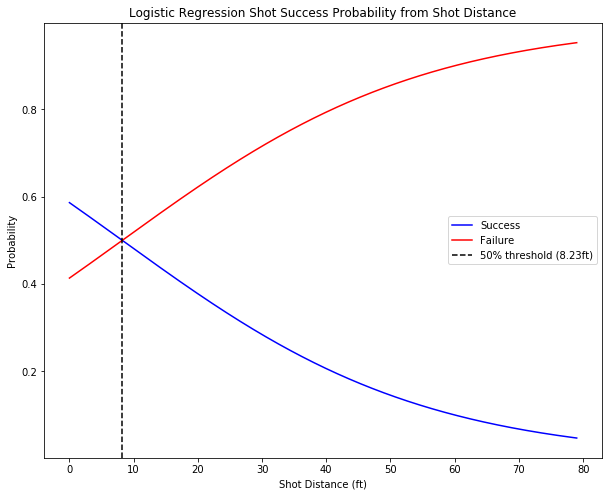

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dist, probs[:,1], label='Success', color='blue')
ax.plot(dist, probs[:,0], label='Failure', color='red')
ax.axvline(x=thresh, linestyle='--', color='black', label=f'50% threshold ({float(thresh):.2f}ft)')
ax.set_xlabel('Shot Distance (ft)')
ax.set_ylabel('Probability')
ax.legend()
plt.title('Logistic Regression Shot Success Probability from Shot Distance')
plt.show()

## Logistic Regression with the full dataset

In [80]:
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup', 
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60*dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type', 'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
lr = LogisticRegression(C=10e4)
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6819
Test Log-Loss: 0.6109
Training Accuracy: 0.6832


In [25]:
lr = LogisticRegression(C=0.5,penalty='l1')
lr.fit(X_train, y_train)
evaluateModel(lr)

Test Accuracy: 0.6822
Test Log-Loss: 0.6103
Training Accuracy: 0.6824


## Model 3: Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [136]:
dt = DecisionTreeClassifier(max_leaf_nodes=10, criterion='entropy')

In [137]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [138]:
evaluateModel(dt)

Test Accuracy: 0.6789
Test Log-Loss: 0.6119
Training Accuracy: 0.6803


In [85]:
viz = dtreeviz(dt, 
               X_train, 
               y_train,
               target_name='shot_made_flag',
               feature_names=list(X_train), 
               class_names={0.0:'shot_made',1.0:'shot_not_made'}  # need class_names for classifier
              ) 

TypeError: list indices must be integers or slices, not numpy.float64

In [111]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

In [139]:
from sklearn.tree import export_graphviz
    
export_graphviz(dt,
                out_file="tree.dot",
                feature_names=list(X_train),
                class_names=['Shot Unsuccessful', 'Shot Successful'],
                rounded=True,
                filled=True
)

In [140]:
!dot -Tpng tree.dot -o tree.png

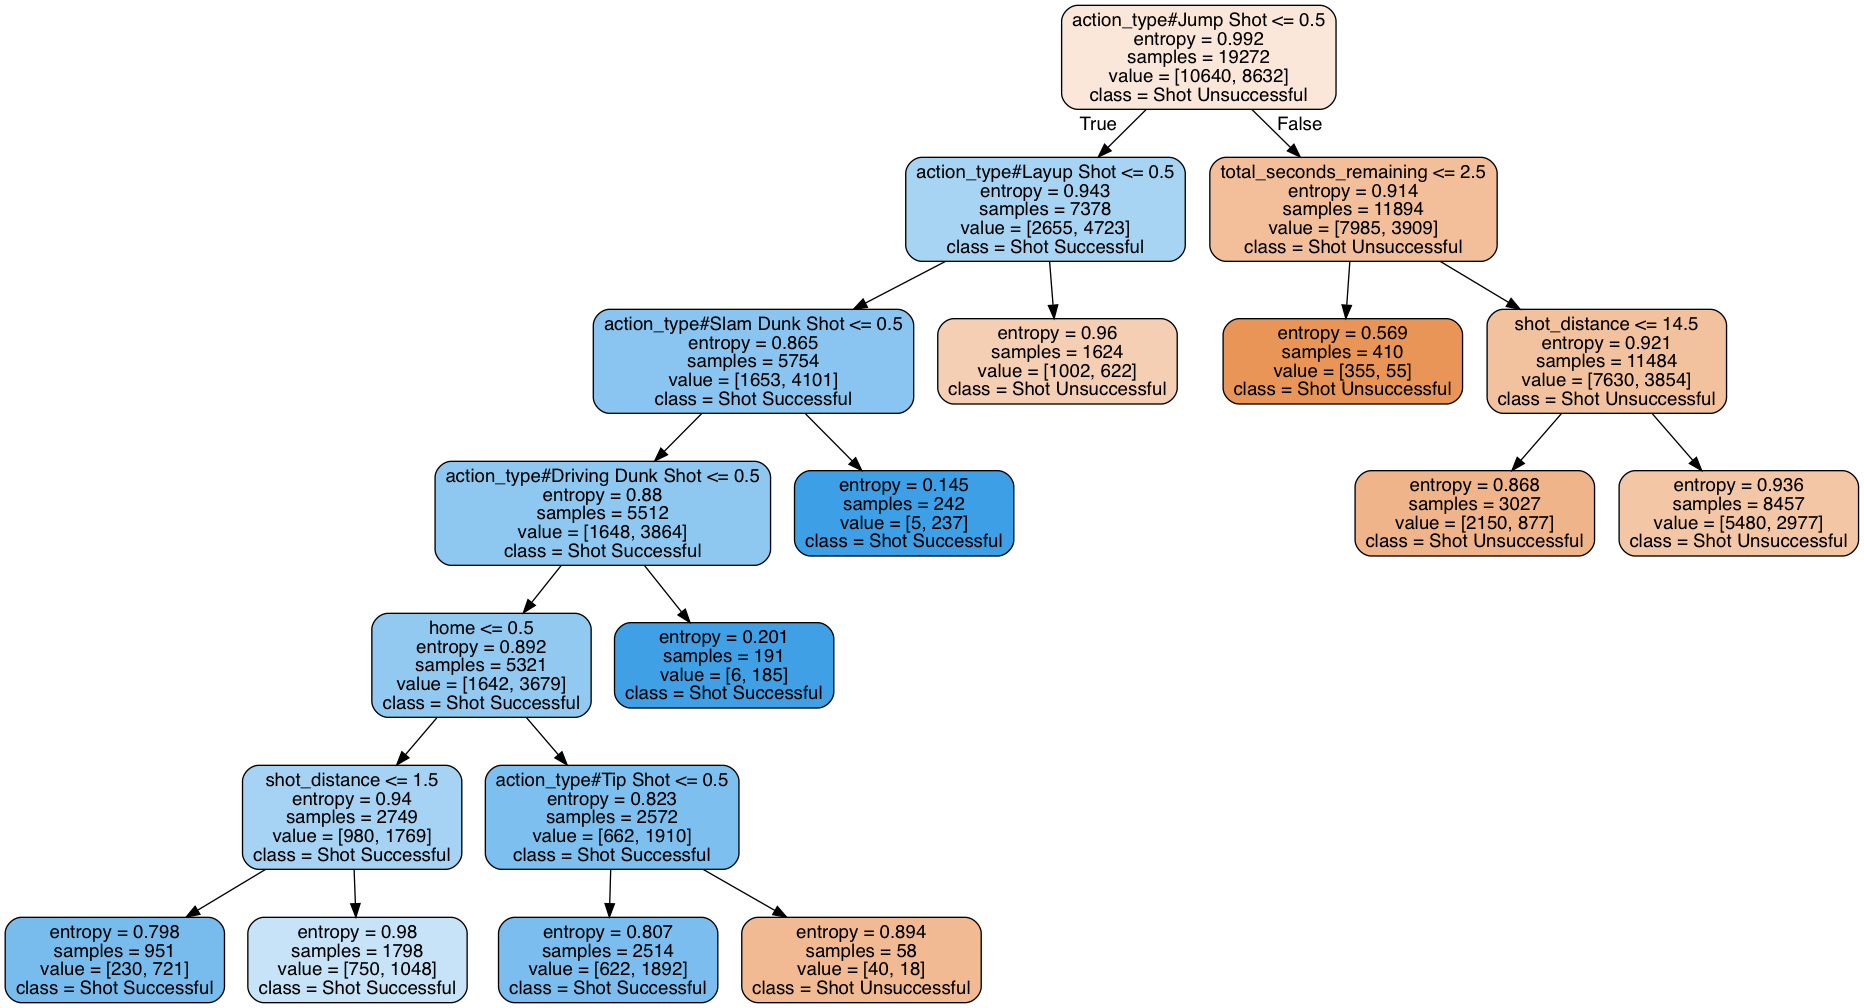

In [141]:
Image(filename='tree.png')

In [142]:
featureImportance(dt)

action_type#Jump Shot: 0.6166864543026478
action_type#Layup Shot: 0.19754316077201362
action_type#Slam Dunk Shot: 0.04375941662539692
shot_distance: 0.04293182378933021
action_type#Driving Dunk Shot: 0.03245614484381102
total_seconds_remaining: 0.028921961820463426
home: 0.021027835652824112
action_type#Tip Shot: 0.01667320219351286
playoffs: 0.0
Def_Rtg: 0.0
action_type#Alley Oop Layup shot: 0.0
action_type#Cutting Layup Shot: 0.0
action_type#Driving Bank shot: 0.0
action_type#Driving Finger Roll Layup Shot: 0.0
action_type#Driving Finger Roll Shot: 0.0
action_type#Driving Floating Bank Jump Shot: 0.0
action_type#Driving Floating Jump Shot: 0.0
action_type#Driving Hook Shot: 0.0
action_type#Driving Jump shot: 0.0
action_type#Driving Layup Shot: 0.0
action_type#Driving Reverse Layup Shot: 0.0
action_type#Driving Slam Dunk Shot: 0.0
action_type#Dunk Shot: 0.0
action_type#Fadeaway Bank shot: 0.0
action_type#Fadeaway Jump Shot: 0.0
action_type#Finger Roll Layup Shot: 0.0
action_type#Finge

## Comparing multiple models

In [12]:
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup', 
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60*dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type', 'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

X = dataset.loc[:, dataset.columns != 'shot_made_flag']
y = dataset['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
models = [('LR',LogisticRegression(C=0.5,penalty='l1')), 
          ('RF', RandomForestClassifier(n_estimators=200, criterion='entropy', min_samples_leaf=5)),
          ('DT', DecisionTreeClassifier(max_leaf_nodes=10, criterion='entropy')),
          ('KNN', KNeighborsClassifier(n_neighbors=100, p=1)),
         ('GB', GradientBoostingClassifier(n_estimators=120, max_depth=4, min_samples_split=4))]

In [21]:
seed = 7 # set seed so that all models are tested on the same CV folds 
scoring = 'neg_log_loss'
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = -cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.4f} ± {cv_results.std():.4f}')

LR: 0.6110 ± 0.0085
RF: 0.6071 ± 0.0067
DT: 0.6112 ± 0.0080
KNN: 0.6608 ± 0.0064
GB: 0.6065 ± 0.0071


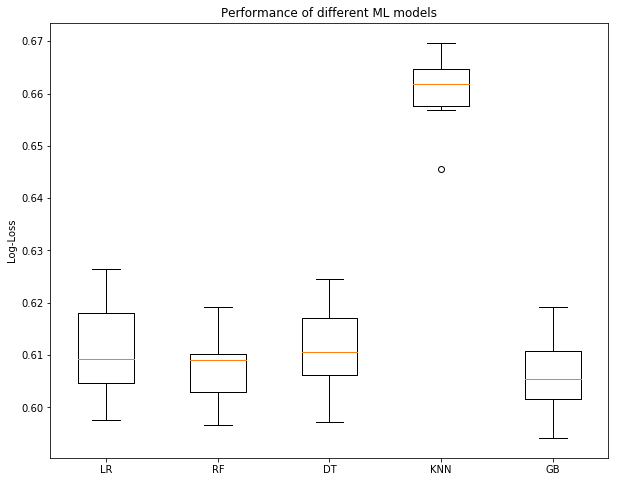

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Log-Loss')
plt.title('Performance of different ML models')
plt.show()